# 결정 트리 (Decision Tree) - 분류

- 스무고개처럼 질문/결정을 통해 데이터를 분류하는 모델
    - 데이터 스케일링 영향이 적음
    - 선형 구조가 아닌 복잡한 구조의 데이터에 적합
    - 과대적합 되기 쉬움 -> 가지치기 등을 통해 과대적합 방지

**하이퍼 파라미터**

<table>
  <thead>
    <tr>
      <th>파라미터 명</th>
      <th>설명</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><code>max_depth</code></td>
      <td>
        트리의 최대 깊이를 규정 (디폴트: None) <br>
        None으로 설정하면 완벽하게 클래스 결정 값이 될 때까지 깊이를 계속 키우며 분할하거나 노드가 가지는 데이터 개수가 <code>min_samples_split</code>보다 작아질 때까지 계속 깊이를 증가시킴 <br>
        깊이가 길어지면 <code>min_samples_split</code> 설정대로 최대 분할하여 과적합할 수 있으므로 적절한 값으로 제어 필요
      </td>
    </tr>
    <tr>
      <td><code>max_features</code></td>
      <td>
        최적의 분할을 위해 고려할 최대의 피처 개수 (디폴트: None / 데이터셋의 모든 피처를 사용해 분할 수행)
        <ul>
          <li><code>int</code> 형으로 지정하면 대상 피처의 개수, <code>float</code> 형으로 지정하면 전체 피처 중 대상 피처의 퍼센트</li>
          <li><code>'sqrt'</code>는 전체 피처 중 sqrt(전체 피처 개수) 즉, 전체 피처 개수의 제곱근만큼 선택</li>
          <li><code>'auto'</code>로 지정하면 sqrt와 동일</li>
          <li><code>'log'</code>는 전체 피처 중 log2(전체 피처 개수) 선택</li>
          <li><code>'None'</code>은 전체 피처 선택</li>
        </ul>
      </td>
    </tr>
    <tr>
      <td><code>min_samples_split</code></td>
      <td>
        노드 분할을 위한 최소 samples (디폴트 : <code>min_samples_split=2</code> == 부모노드의 sample수가 2 이상인 경우 분할, 자식노드의 sample수가 2이하일 수 있음) <br>
        작게 설정할 수록 과적합 가능성 증가
      </td>
    </tr>
    <tr>
      <td><code>min_samples_leaf</code></td>
      <td>
        분할 이후 만족시켜야 할 sample 최소 개수 (<code>min_samples_leaf=2</code>일 때, 분할 이후 자식노드의 sample수가 2개 이상이 된다면 부모노드를 분할) <br>
        작게 설정할수록 과적합 가능성 증가
      </td>
    </tr>
    <tr>
      <td><code>max_leaf_nodes</code></td>
      <td>분할 이후 leaf_node 최대개수</td>
    </tr>
    <tr>
      <td><code>criterion</code></td>
      <td>
        분할을 위해 사용할 성능 평가 지표 설정 <br>
        <code>gini</code> 또는 <code>entropy</code> 값을 사용할 수 있으며, <code>gini</code>는 지니 계수를, <code>entropy</code>는 정보 이득을 기반으로 분할 기준을 결정
      </td>
    </tr>
    <tr>
      <td><code>min_weight_fraction_leaf</code></td>
      <td>
        리프 노드가 전체 가중치에서 차지해야 하는 최소 비율 (디폴트: 0) <br>
        특정 클래스의 데이터가 지나치게 적은 경우 과적합을 방지하기 위해 사용
      </td>
    </tr>
  </tbody>
</table>

In [44]:
# 위의 하이퍼 파라미터들은 과적합 방지에 초점이 맞춰져 있다

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### graphviz 설치
- 그래프 시각화를 위한 오픈소스 소프트웨어 도구
1. os에 설치
2. python wrapper package 설치
3. plot_tree 사용

In [46]:
# !pip install graphviz

### wine 이진 분류
- 와인 품질 데이터셋을 가공한 레드/화이트 와인 이진분류 데이터셋
    - 0: 레드 와인
    - 1: 화이트 와인

In [47]:
# 데이터 로드
wine_df = pd.read_csv('./data/wine_simple.csv')
wine_df

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0
...,...,...,...,...
6492,11.2,1.6,3.27,1.0
6493,9.6,8.0,3.15,1.0
6494,9.4,1.2,2.99,1.0
6495,12.8,1.1,3.34,1.0


In [48]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [49]:
wine_df.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [ ]:
# 데이터 분리 및 스케일링
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = wine_df.drop('class', axis=1)
y = wine_df['class']
y.value_counts()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape, X_test.shape)

# 스케일링을 하지 않아도 숫자는 변해도 지니불순도는 변하지 않아 분할에 변화가 없다. -> 스케일링의 영향이 적다
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

(4872, 3) (1625, 3)


In [51]:
# 모델 학습 및 평가
from sklearn.tree import DecisionTreeClassifier

# dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf = DecisionTreeClassifier(random_state=0, max_depth=3)    # max_depth : 사전 가지치기. 트리의 최대 깊이를 제한. -> 설정하기 전보다 과적합이 해결됨

dt_clf.fit(X_train, y_train)
dt_clf.score(X_train, y_train), dt_clf.score(X_test, y_test)

(0.8433908045977011, 0.8584615384615385)

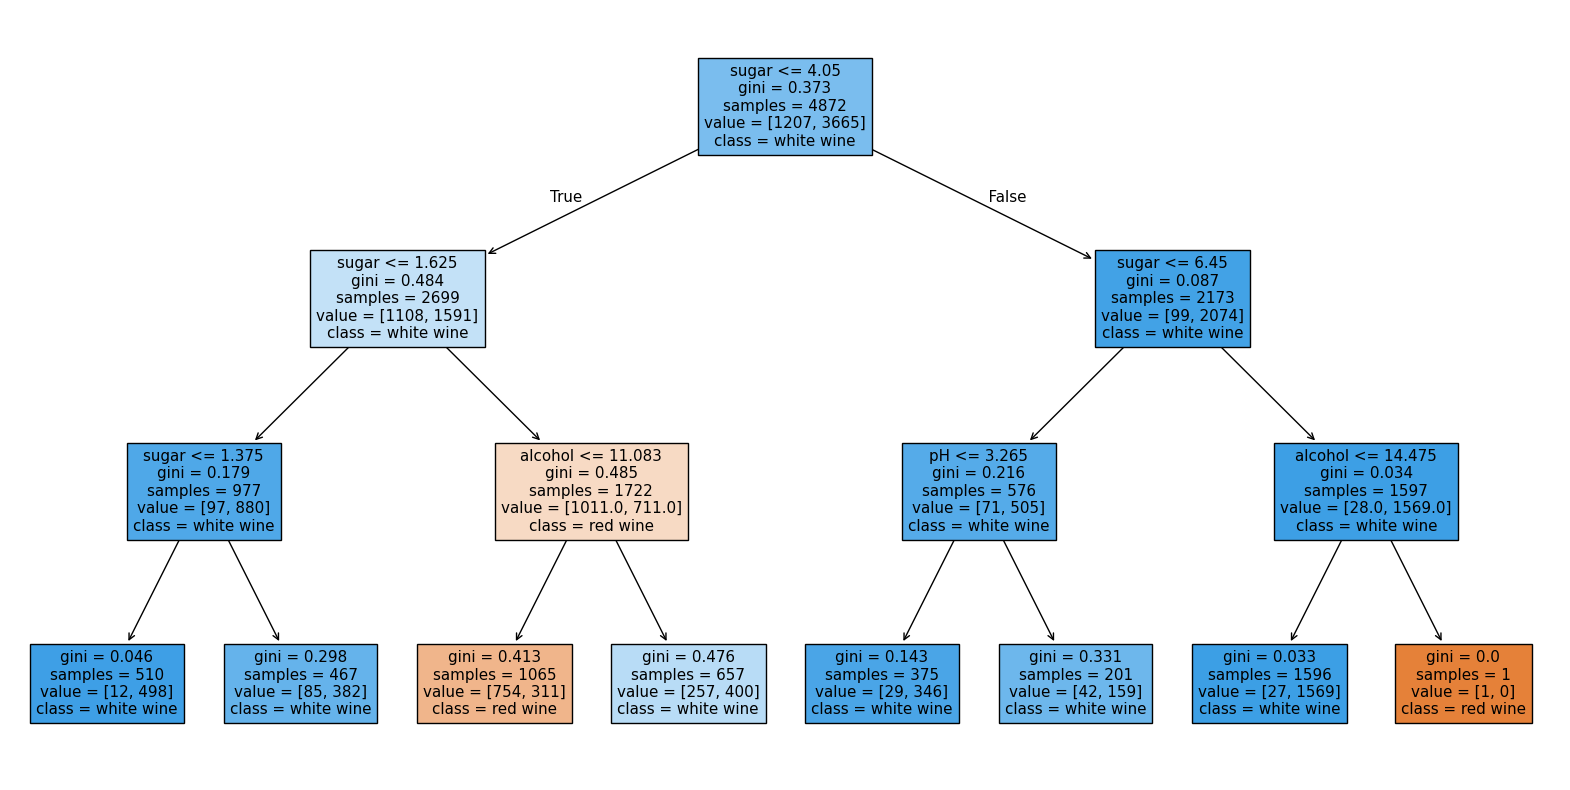

'\n# 루트노드\nsugar <= -0.284         # DecisionTreeClassifier가 정한 분할 기준. (자식 노드로 내려갔을때 gini계수가 최대로 낮아질 수 있는 분할 기준)\ngini = 0.373            # 지니계수 = 1 - (음성클래스비율^2 + 양성클래스비율^2)  (음성클래스 : 0)\nsamples = 4872          # 현재 노드의 전체 샘플수 (학습용으로 분할된 샘플의 개수. 즉 X_train 4872개)\nvalue = [1207, 3665]    # 클래스별 샘플의 개수 (0번 클래스가 1207개, 1번 클래스가 3665개)\nclass = white wine      # 현재 노드의 클래스 (value에서 많은 클래스 선택택)\n'

In [52]:
from sklearn.tree import plot_tree
# 모델이 학습한 결과를 보여줌
plt.figure(figsize=(20, 10))
# plot_tree(dt_clf)
plot_tree(
    dt_clf,     # 대상이 되는 모델
    filled=True,    # 색 채우기 옵션 (특정 클래스의 비율 표현)
    feature_names=X.columns, # 특성 이름
    class_names=['red wine', 'white wine']  # 클래스 이름 / 노드에 포함된 것 중 더 많은 특성이 포함된 클래스 이름이 표기된다
    # max_depth=3 # 시각화하면서 max_depth를 제한해주면 3까지 그려주기는 하지만 객체에서 max_depth를 설정한 것과는 다르게 분할이 끝난 것은 아니다. 단지 아래부분을 생략한 것 뿐.
)
plt.savefig('wine_simple.png')   # 시각화된 이미지를 직접 저장할 수도 있지만 plt.savefig('파일명.확장자')로 이미지를 저장할 수도 있다
plt.show()

"""
# 루트노드
sugar <= -0.284         # DecisionTreeClassifier가 정한 분할 기준. (자식 노드로 내려갔을때 gini계수가 최대로 낮아질 수 있는 분할 기준)
gini = 0.373            # 지니계수 = 1 - (음성클래스비율^2 + 양성클래스비율^2)  (음성클래스 : 0)
samples = 4872          # 현재 노드의 전체 샘플수 (학습용으로 분할된 샘플의 개수. 즉 X_train 4872개)
value = [1207, 3665]    # 클래스별 샘플의 개수 (0번 클래스가 1207개, 1번 클래스가 3665개)
class = white wine      # 현재 노드의 클래스 (value에서 많은 클래스 선택택)
"""

In [53]:
# 리프노드는 gini계수가 맨 위에 있고, 특성(sugar,alcohol,pH)에 대한 조건이 적혀있지 않다. 더이상 분할하지 않기 때문에 표기할 필요가 없기 때문.

In [54]:
# 루트 노드의의 지니 불순도 직접 계산
1 - ((1207 / 4872) ** 2 + (3665 / 4872) ** 2)   # 1 - (음성클래스의 비율^2 + 양성클래스의 비율^2)

0.37273200500969317

In [55]:
# 특성 중요도
# [alcohol, sugar, pH] 중요도 
# - 지니불순도 감소에 기여한 만큼 중요도가 높아짐 
dt_clf.feature_importances_ # 모델이 판단한 각 특성의 중요도(인덱스 순으로)

array([0.11483515, 0.87892904, 0.00623581])

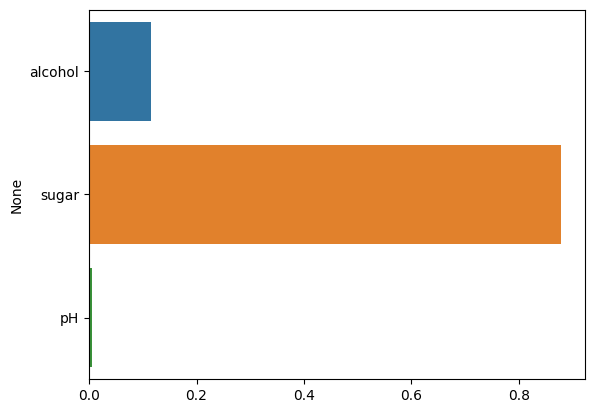

In [56]:
sns.barplot(x=dt_clf.feature_importances_, y=X.columns, hue=X.columns)
plt.show()

##### iris 다중분류

In [84]:
# 데이터 로드
from sklearn.datasets import load_iris
iris_data = load_iris() # data: X 데이터, target: y 데이터

iris_data

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [89]:
# 모델 학습 및 평가
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, random_state=0)

iris_dt = DecisionTreeClassifier(random_state=0, max_depth=3)
iris_dt.fit(X_train, y_train)
iris_dt.score(X_train, y_train), iris_dt.score(X_test, y_test)



(0.9821428571428571, 0.9736842105263158)

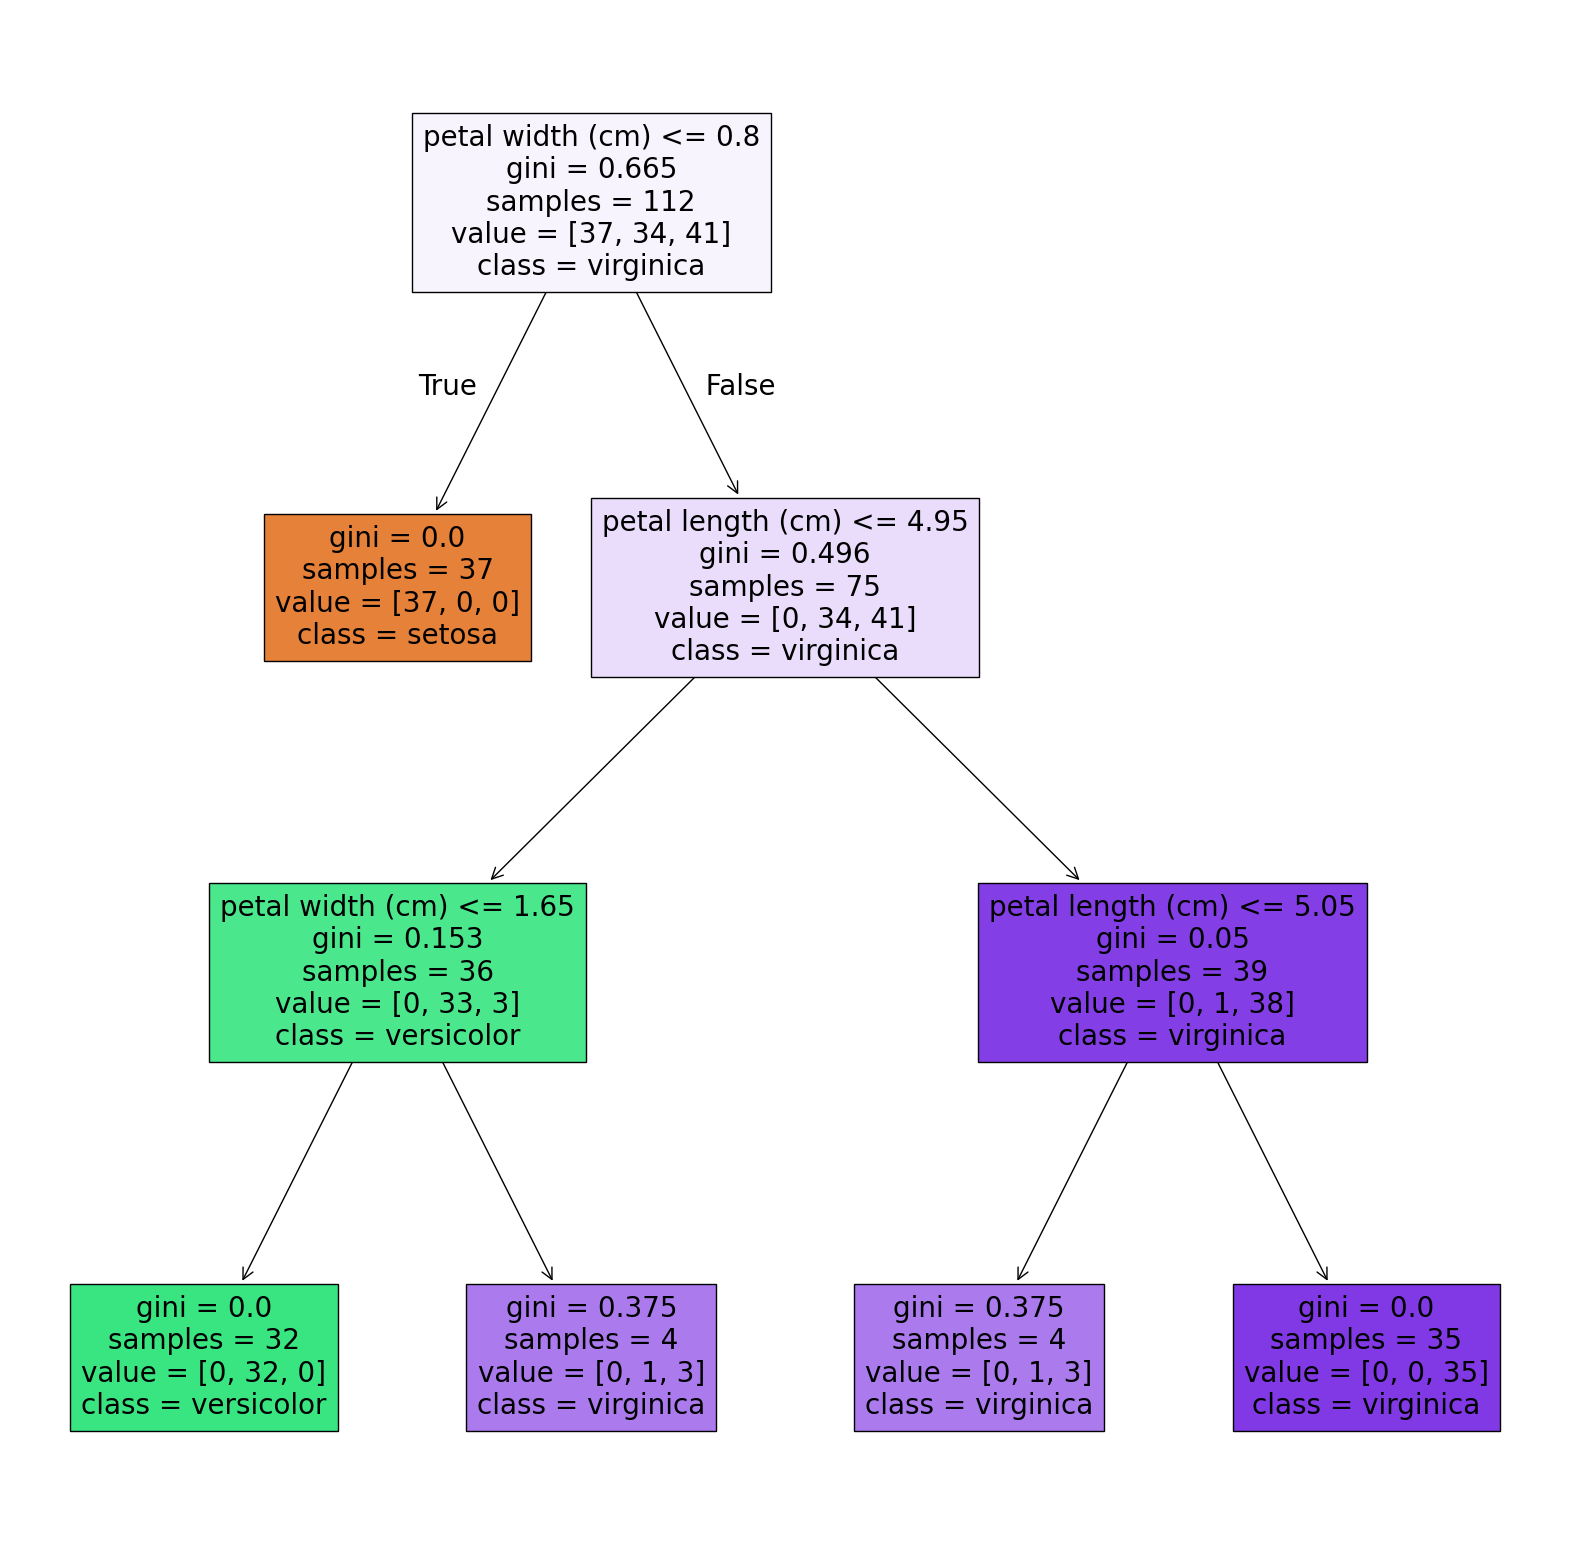

In [90]:
# 트리모델 시각화 
plt.figure(figsize=(20, 20))

plot_tree(
    iris_dt,     
    filled=True,
    feature_names=iris_data.feature_names,
    class_names=iris_data.target_names 
)

plt.show()

# DecisionTreeRegressor - 회귀
- 각 노드에서 MSE를 최소화하는 방향으로 노드 분할
- 최종 노드(리프 노드)에서는 각 샘플들의 평균값을 계산해 예측값으로 사용

In [ ]:
# 데이터 로드
from sklearn.datasets import fetch_california_housing

housing_data = fetch_california_housing()
housing_df = pd.DataFrame(housing_data.data, columns=housing_data.feature_names)
housing_df[housing_data.target_names[0]] = housing_data.target  # 타겟 데이터 넣어줌
housing_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [95]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [96]:
# 데이터 준비 (분리)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(housing_data.data, housing_data.target, random_state=0)

In [103]:
# 모델 훈련과 평가
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=8)

# 학습
dt_reg.fit(X_train, y_train)

# 예측
pred_train = dt_reg.predict(X_train)
pred_test = dt_reg.predict(X_test)

# 평가
mse_train = mean_squared_error(y_train, pred_train)
r2_train = r2_score(y_train, pred_train)

mse_test = mean_squared_error(y_test, pred_test)
r2_test = r2_score(y_test, pred_test)

print('train 데이터 평가:', mse_train, '|', r2_train)
print('test 데이터 평가:', mse_test, '|', r2_test)

train 데이터 평가: 0.32342609927780885 | 0.7576694150548335
test 데이터 평가: 0.4391632362998888 | 0.6677663736640318


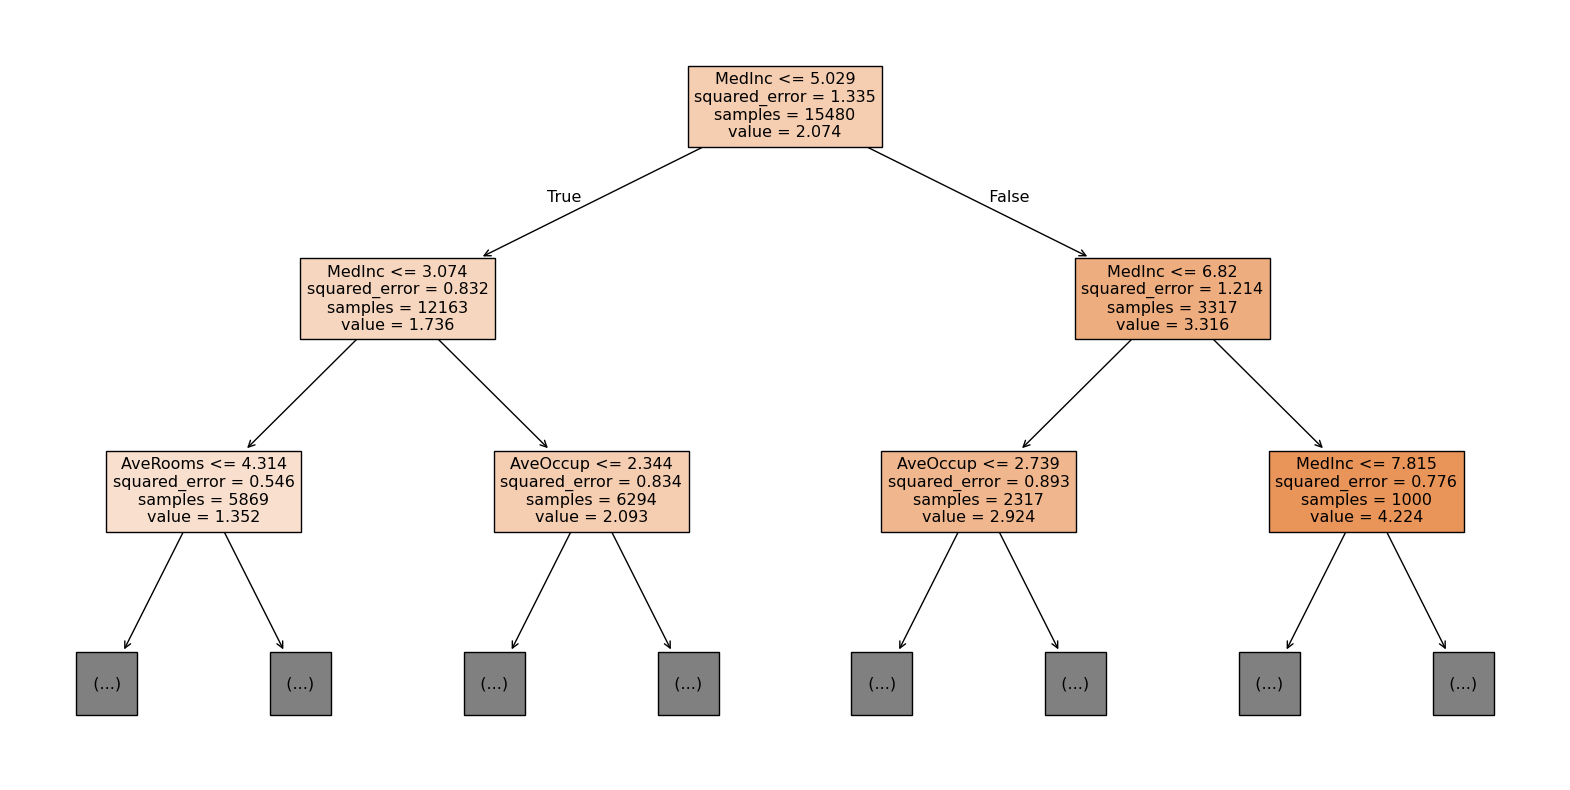

In [106]:
# 시각화
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    dt_reg,
    filled=True,
    feature_names=housing_data.feature_names,
    max_depth=2
)
plt.show()

<Axes: >

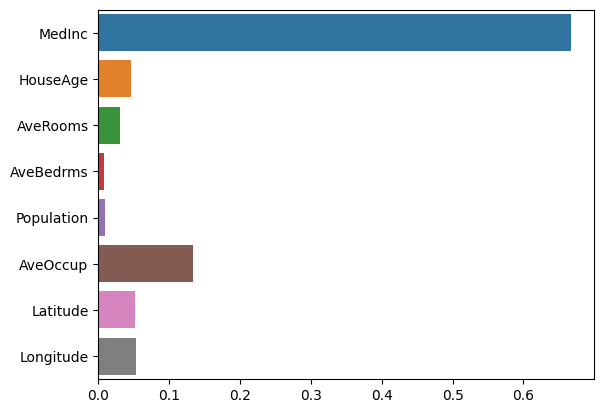

In [ ]:
# 특성 중요도
dt_reg.feature_importances_

sns.barplot(
    x=dt_reg.feature_importances_, 
    y=housing_data.feature_names, 
    hue=housing_data.feature_names)